# 3. 비지도학습 알고리즘 (차원축소, 군집분석, 연관규칙분석)

## [연습문제]

### 1. 신용카드 데이터
다음은 신용 카드 사용자 데이터이다. 데이터는 신용카드 사용 행태를 나타내는 입력 변수들 구성되어 있다. <br>
데이터 컬럼 정의서는 아래와 같을 때, 2개의 군집 분석 알고리즘으로 각각 군집을 생성하고 군집 생성 과정을 설명하시오. (데이터 링크는 아래 코드 참조)
> 1. CUST_ID: 신용카드 사용자 ID
> 2. BALANCE: 구매 계좌 잔액
> 3. BALANCE_FREQUENCY: 구매 계좌 잔액이 업데이트 되는 빈도 지수, 0(자주 업데이트되지 않음)~1(자주 업데이트 됨) 
> 4. PURCHASES: 구매 계좌로부터의 구매액
> 5. PURCHASES_FREQUENCY: 구매 빈도 지수, 0(자주 구매하지 않음)~1(자주 구매함) 6. PURCHASES_TRX: 구매 거래 건수

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice10_credit_card.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_TRX
0,C10001,40.900749,0.818182,95.40,0.166667,2
1,C10002,3202.467416,0.909091,0.00,0.000000,0
2,C10003,2495.148862,1.000000,773.17,1.000000,12
3,C10004,1666.670542,0.636364,1499.00,0.083333,1
4,C10005,817.714335,1.000000,16.00,0.083333,1


In [2]:
def resume(df):
    print(df.shape)
    tmp = pd.DataFrame()
    tmp['dtype'] = df.dtypes
    tmp['isna'] = df.isna().sum()
    tmp['nunique'] = df.nunique()
    tmp['1st'] = df.iloc[0,:]
    tmp['2nd'] = df.iloc[1,:]
    return tmp 
resume(df)

(8950, 6)


,dtype,isna,nunique,1st,2nd
CUST_ID,object,0,8950,C10001,C10002
BALANCE,float64,0,8871,40.900749,3202.467416
BALANCE_FREQUENCY,float64,0,43,0.818182,0.909091
PURCHASES,float64,0,6203,95.4,0.0
PURCHASES_FREQUENCY,float64,0,47,0.166667,0.0
PURCHASES_TRX,int64,0,173,2,0


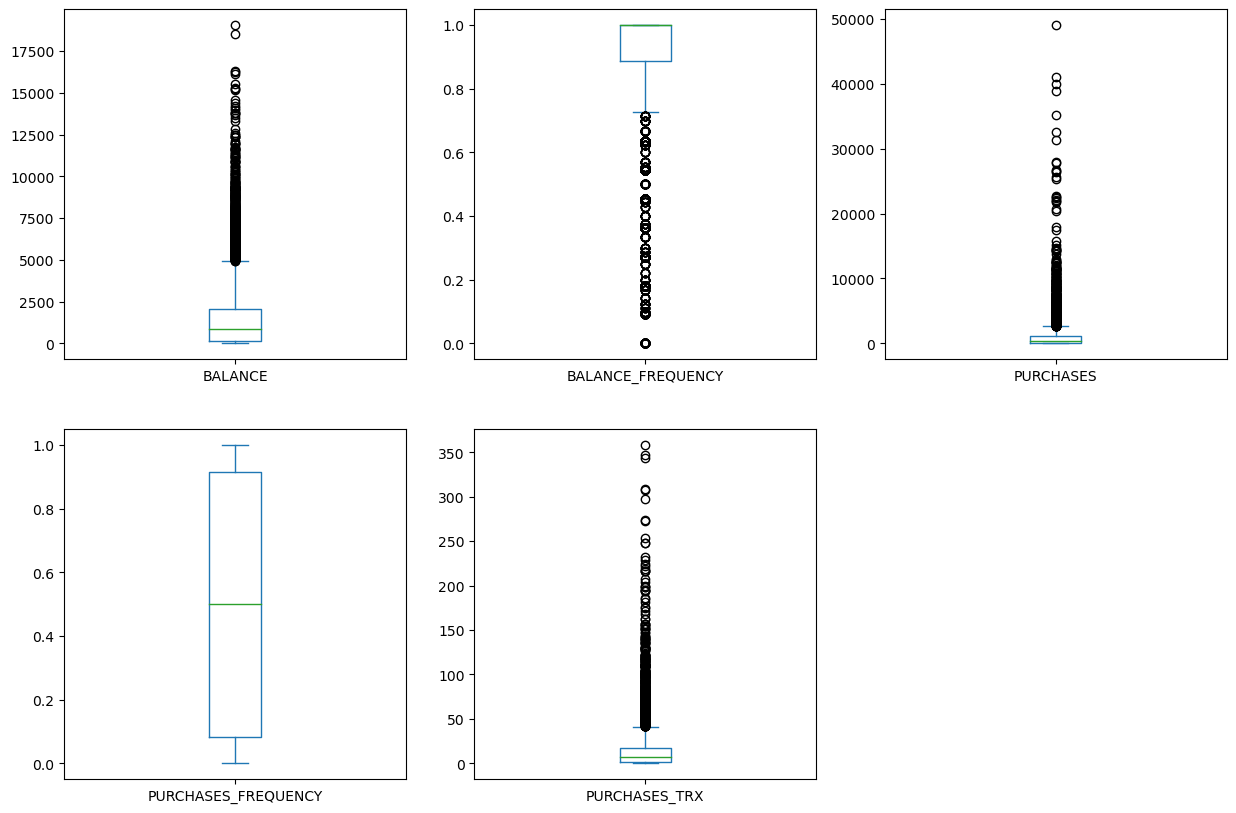

In [3]:
df.plot(kind = 'box', subplots = True, layout = (2,3), figsize = (15, 10));

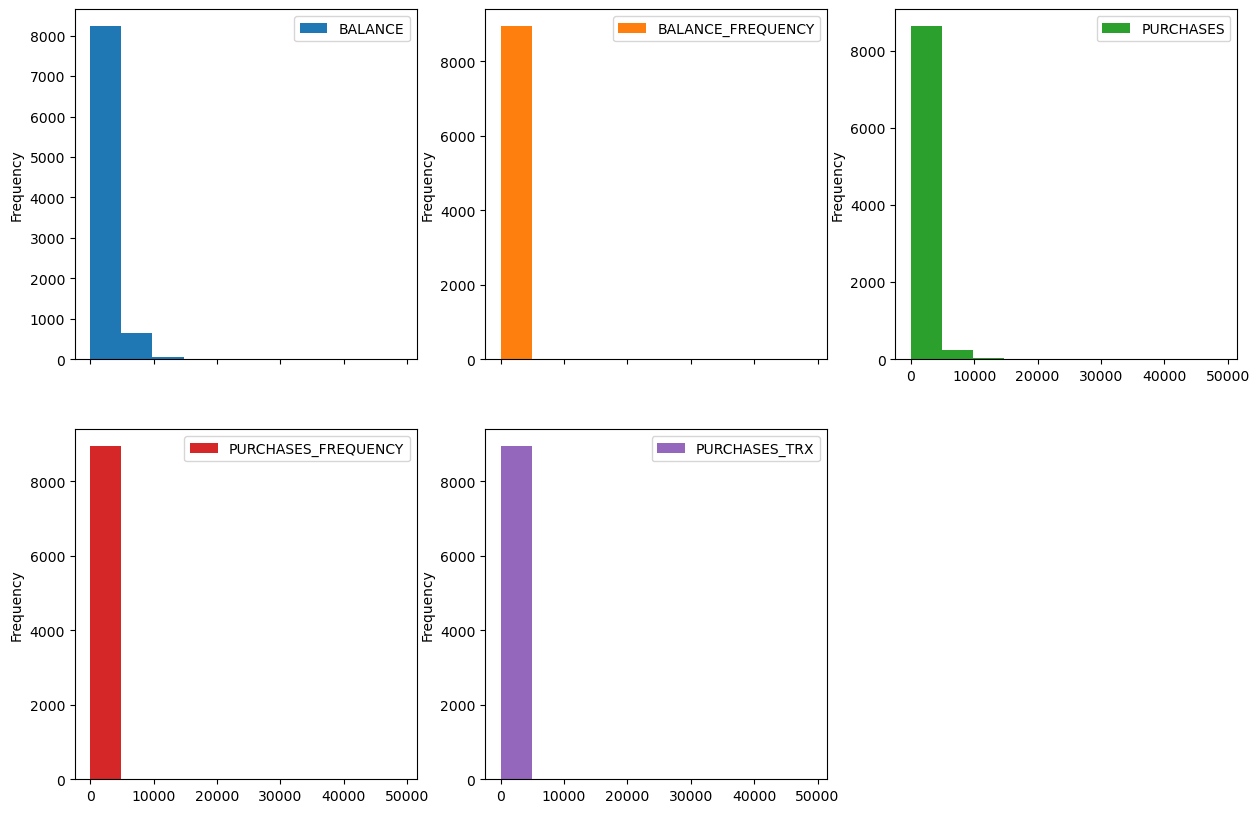

In [4]:
df.plot(kind = 'hist', subplots = True, layout = (2,3), figsize = (15, 10));

데이터 쏠림이 심하여 스케일링 필요해보임

In [5]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_TRX
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,0.490351,14.709832
std,2081.531879,0.236904,2136.634782,0.401371,24.857649
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,128.281915,0.888889,39.635000,0.083333,1.000000
50%,873.385231,1.000000,361.280000,0.500000,7.000000
75%,2054.140036,1.000000,1110.130000,0.916667,17.000000
max,19043.138560,1.000000,49039.570000,1.000000,358.000000


<AxesSubplot:>

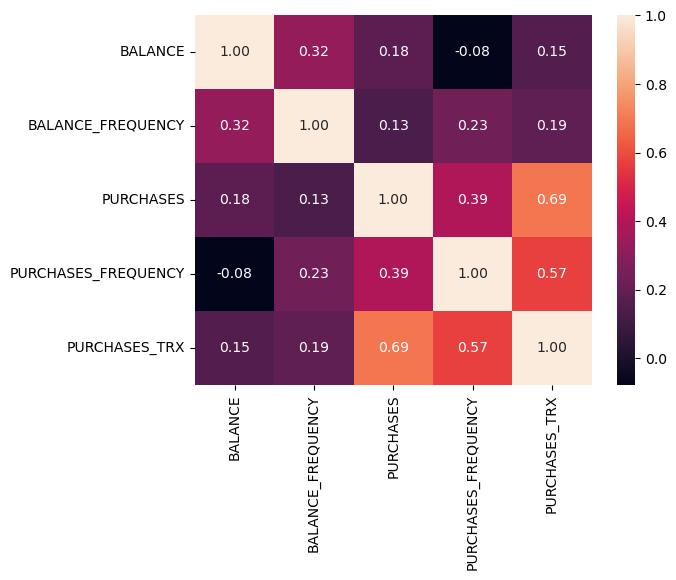

In [6]:
import seaborn as sns
sns.heatmap(df.iloc[:,1:].corr(),
           annot = True,
           fmt='.2f',)

- 'PURCHASES'는 'PURCHASES_TRX'와 강한 양의 상관관계, 'PURCHASES_FREQUENCY'와 약한 양의 상관관계를 가지고 있음
- 'PURCHASES_TRX'와 'PURCHASES_FREQUENCY'는 양의 상관관계
- 'balance'와 'balance_frequency'는 약한 양의 상관관계 : balance_frequency는 무시해도 상관없을 듯

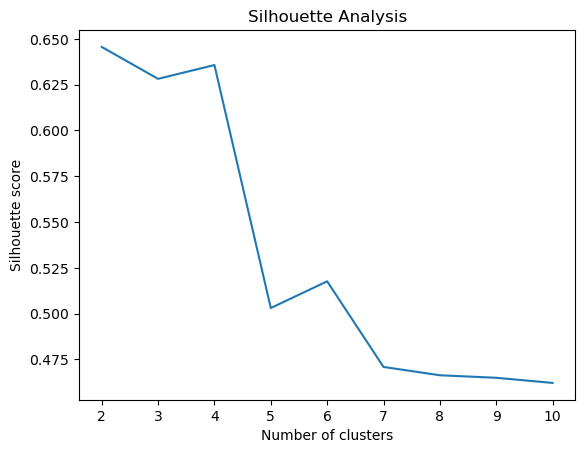

In [7]:
'''
실루엣 분석은 각 데이터 포인트가 클러스터에 잘 할당되었는지를 평가 
실루엣 계수(Silhouette Coefficient)는 -1에서 1 사이의 값을 가지며, 
1에 가까울수록 클러스터링이 잘 되었음을 의미. 실루엣 계수가 가장 높은 K 값이 최적의 클러스터 개수
'''
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import warnings 
warnings.filterwarnings('ignore')

# 입력 변수 선택
X = df[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 
          'PURCHASES_FREQUENCY', 'PURCHASES_TRX']]

# 실루엣 분석을 통한 K 값 결정
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

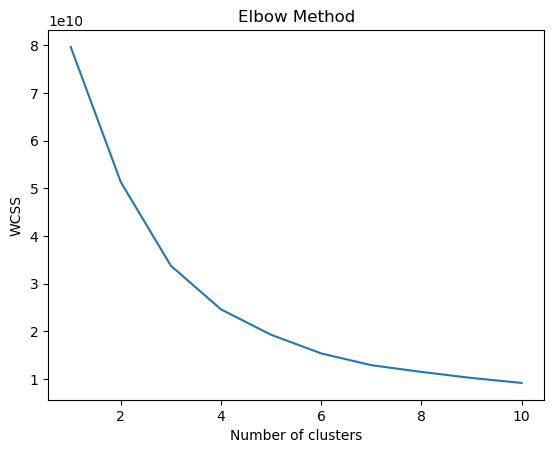

In [8]:
# Elbow 방법을 통한 K 값 결정
'''K-Means 알고리즘의 WCSS(Within-Cluster Sum of Squares) 값을 계산하고, 그래프에 플롯팅
그래프에서 급격한 꺾임이 발생하는 지점(팔꿈치 모양)이 최적의 K'''

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

실루엣분석 및 ELBOW기법에 따라 최적의 k는 4개

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# 데이터 로드
url = "https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice10_credit_card.csv"
data = pd.read_csv(url)

# 입력 변수 선택
X = data[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'PURCHASES_FREQUENCY', 'PURCHASES_TRX']]

# 1. K-Means 알고리즘
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
data['kmeans_cluster'] = kmeans.labels_

# 2. 계층적 군집분석
Z = linkage(X, method='ward')
cluster_labels = fcluster(Z, t=4, criterion='maxclust')
data['hier_cluster'] = cluster_labels

# 결과 출력
data.head()

E:\miniconda\envs\tw311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_TRX,kmeans_cluster,hier_cluster
0,C10001,40.900749,0.818182,95.40,0.166667,2,0,1
1,C10002,3202.467416,0.909091,0.00,0.000000,0,0,4
2,C10003,2495.148862,1.000000,773.17,1.000000,12,0,1
3,C10004,1666.670542,0.636364,1499.00,0.083333,1,0,1
4,C10005,817.714335,1.000000,16.00,0.083333,1,0,1


In [5]:
kmeans.fit(X)

E:\miniconda\envs\tw311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=0)

- K-Means 알고리즘


1. K-Means 알고리즘은 데이터를 K개의 클러스터로 분할
2. K개의 초기 클러스터 중심(centroid)을 무작위로 선택
3. 각 데이터 포인트를 가장 가까운 클러스터 중심에 할당
4. 할당된 데이터 포인트들의 평균을 새로운 클러스터 중심으로 업데이트
5. 클러스터 중심이 더 이상 변하지 않을 때까지 반복
    - 위 코드에서는 K=2로 설정하여 2개의 클러스터 생성


- 계층적 군집분석


1. 데이터 포인트를 계층적으로 그룹화
2. 각 데이터 포인트를 개별 클러스터로 시작
3. 가장 가까운 두 클러스터를 병합하고, 이를 반복
4. 덴드로그램(dendrogram)을 통해 클러스터 구조를 시각화
    - 위 코드에서는 ward 연결 방법을 사용하여 2개의 클러스터를 생성

두 알고리즘 모두 입력 변수로 사용된 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'PURCHASES_FREQUENCY', 'PURCHASES_TRX'를 기반으로 유사한 신용카드 사용 패턴을 가진 고객들을 그룹화


K-Means 알고리즘은 클러스터 중심을 기반으로 데이터를 분할하므로 구형 클러스터에 적합. 반면 계층적 군집분석은 클러스터의 모양에 제약이 없어 더 유연한 클러스터링이 가능


두 알고리즘 모두 장단점이 있으므로, 데이터의 특성과 목적에 따라 적절한 알고리즘을 선택하는 것이 중요
또한, 클러스터 수, 거리 측정 방법, 연결 방법 등의 하이퍼파라미터 튜닝도 필요

In [21]:
from sklearn.cluster import DBSCAN

# DBSCAN 알고리즘 적용 
dbscan = DBSCAN(eps=0.3, min_samples=5)
cluster_labels = dbscan.fit_predict(X)
data['dbscan_cluster'] = cluster_labels


- DBSCAN(Density-Based Spatial Clustering of Applications with Noise)



1. 데이터 포인트들의 밀도를 계산합니다. 밀도는 특정 반경(eps) 내에 있는 데이터 포인트의 개수로 정의
2. 밀도가 min_samples 이상인 데이터 포인트를 '핵심 포인트(core point)'로 정의
3. 핵심 포인트와 인접한 데이터 포인트들을 같은 클러스터로 할당
4. 밀도가 낮은 데이터 포인트들은 노이즈로 분류

    - 위 코드에서는 eps=0.5, min_samples=5로 설정. 
      (반경 0.5 내에 최소 5개의 데이터 포인트가 있어야 핵심 포인트로 간주한다는 의미)


- DBSCAN 알고리즘의 장점

    1. 클러스터의 모양에 제약이 없음
    2. 노이즈 데이터를 별도로 처리 가능
    3. 클러스터 개수를 미리 지정할 필요가 없음

- 단점 : eps와 min_samples 값에 민감


DBSCAN은 K-Means나 계층적 군집분석과 달리 밀도 기반으로 클러스터를 생성하므로, 밀도가 불균일한 데이터에 적합. 신용카드 사용 패턴 데이터에는 다양한 밀도 분포가 존재할 수 있으므로, DBSCAN 알고리즘이 유용

In [22]:
resume(data)

(8950, 9)


,dtype,isna,nunique,1st,2nd
CUST_ID,object,0,8950,C10001,C10002
BALANCE,float64,0,8871,40.900749,3202.467416
BALANCE_FREQUENCY,float64,0,43,0.818182,0.909091
PURCHASES,float64,0,6203,95.4,0.0
PURCHASES_FREQUENCY,float64,0,47,0.166667,0.0
PURCHASES_TRX,int64,0,173,2,0
kmeans_cluster,int32,0,4,1,1
hier_cluster,int32,0,4,1,4
dbscan_cluster,int64,0,4,-1,-1


### 2. 두 모델을 비교하고, 더 타당한 모델을 선택하시오.

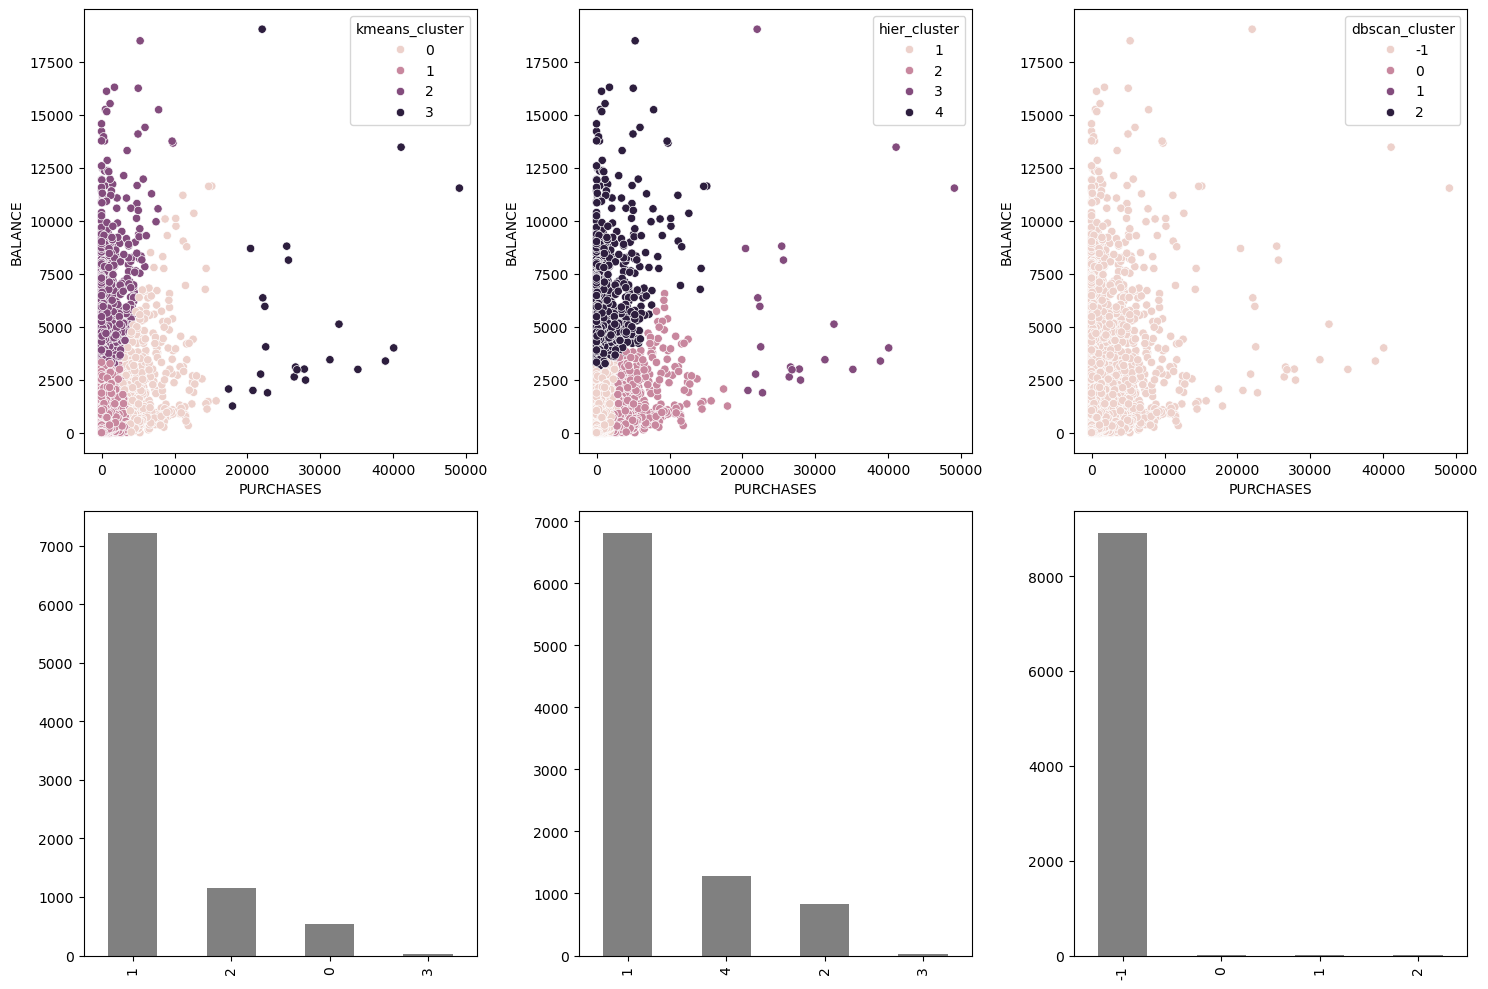

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3,figsize = (15,10))

axes = axes.flatten()
for idx, (ax, c) in enumerate(zip(axes, ['kmeans_cluster', 'hier_cluster', 'dbscan_cluster'])):
    sns.scatterplot(data, x='PURCHASES', y='BALANCE', hue = c, ax=ax)
    data[c].value_counts().plot(kind='bar', ax=axes[3+idx], color = 'grey')
plt.tight_layout()
plt.show()

계층적 군집분석이 비선형적인 특성까지 가장 잘 잡아내는 것을 확인하였다

### 3. 선택한 모델로 생성한 군집들의 고객 특성을 분석하시오.

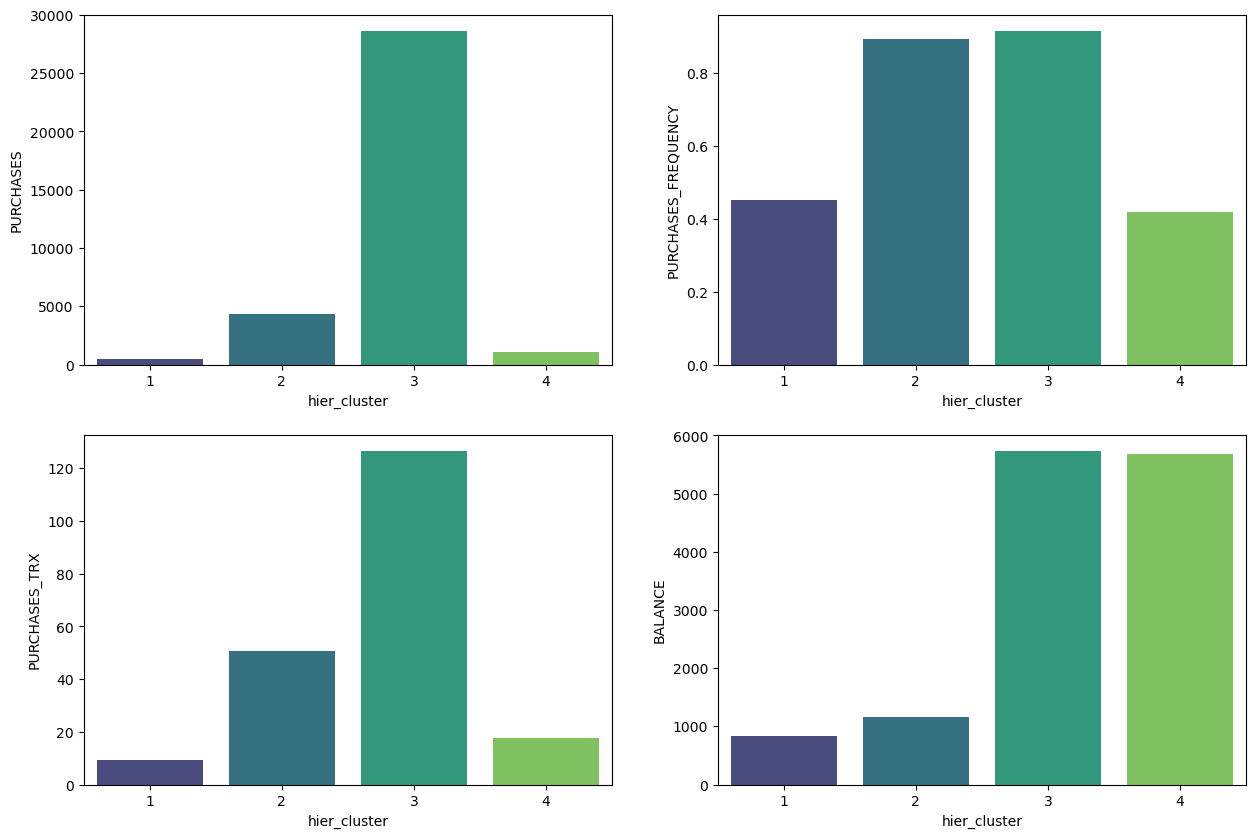

In [16]:
# 군집별 특성 분석
cluster_stats = data.iloc[:,1:].groupby('hier_cluster').mean()

columns = ['PURCHASES', 'PURCHASES_FREQUENCY','PURCHASES_TRX','BALANCE']

fig, axes = plt.subplots(2,2,figsize = (15,10))

axes = axes.flatten()

for ax, c in zip(axes,columns):
# 군집별 특성 시각화
    sns.barplot(x= cluster_stats.index, y=c, data=cluster_stats, palette='viridis', ax=ax,
               )

plt.show()


BALANCE: 구매 계좌 잔액<br>
BALANCE_FREQUENCY: 구매 계좌 잔액이 업데이트 되는 빈도 지수, 0(자주 업데이트되지 않음) ~ 1(자주 업데이트 됨)<br>
PURCHASES: 구매 계좌로부터의 구매액<br>
PURCHASES_FREQUENCY: 구매 빈도 지수, 0(자주 구매하지 않음)~1(자주 구매함) <br>6. PURCHASES_TRX: 구매 거래 건수<br>

- 1 번 : 구매금액 낮고, 구매빈도나 구매당 거래액도 비교적 낮은 집단
- 2 번 : 구매금액 낮으나 빈도는 높은편, 구매당 거래액은 보통수준
- 3 번 : 구매금액 높으며, 빈도 및 구매당 거래액 모두 높음
- 4 번 : 잔고는 높으나 구매로 이어지지 않는 고객, 구매빈도 및 거래액 모두 낮음

### 4. 고객 특성이 다음과 같다면 어느 군집으로 분류하는 것이 타당한지 서술하시오.
>  BALANCE: 3000, BALANCE_FREQUENCY: 1,
PURCHASES: 6000, PURCHASES_FREQUENCY: 1, PURCHASES_TRX: 100

In [18]:
import numpy as np
columns = ['PURCHASES', 'PURCHASES_FREQUENCY','PURCHASES_TRX','BALANCE']

cluster_stats = data.iloc[:,1:].groupby('hier_cluster').mean()

new_customer = pd.DataFrame({'BALANCE': [3000], 
                             'BALANCE_FREQUENCY': [1],
                             'PURCHASES': [6000],
                             'PURCHASES_FREQUENCY': [1],
                             'PURCHASES_TRX': [100]})

# 새로운 고객 데이터와 군집 중심 간 거리 계산
distances = []
for cluster_center in cluster_stats[columns].values:
    distance = ((new_customer[columns] - cluster_center)**2).sum(axis=1)**0.5
    distances.append(distance.values[0])

# 가장 가까운 군집 선택
closest_cluster = np.array(distances).argmin() + 1
print(f"새로운 고객은 군집 {closest_cluster}에 속합니다.")

새로운 고객은 군집 2에 속합니다.


### 5. 각 군집들을 대상으로 마케팅 전략을 수립하시오.

제시된 4개의 군집에 대해 다음과 같은 마케팅 전략을 수립할 수 있습니다.


1번 군집 (구매금액 낮고, 구매빈도나 구매당 거래액도 비교적 낮은 집단)



- 목표: 구매 활성화 및 고객 전환
- 전략:

1. 할인 프로모션 및 이벤트 제공
2. 신규 상품 및 서비스 홍보
3. 구매 장벽 제거 (편리한 결제 방식, 배송 옵션 등)
4. 타겟 마케팅 (관심사 기반 맞춤 광고)



2번 군집 (구매금액 낮으나 빈도는 높은 편, 구매당 거래액은 보통 수준)



- 목표: 구매금액 증대 및 고객 유지
- 전략:

1. 고객 등급제 및 리워드 프로그램 도입
2. 크로스셀링 및 업셀링 (관련 상품 및 프리미엄 상품 추천)
3. 맞춤형 프로모션 및 할인 쿠폰 제공
4. 고객 관계 관리 (CRM) 강화



3번 군집 (구매금액 높으며, 빈도 및 구매당 거래액 모두 높음)



- 목표: 고객 유지 및 관계 강화
- 전략:

1. VIP 고객 프로그램 운영
2. 프리미엄 서비스 및 혜택 제공
3. 고객 맞춤형 마케팅 (개인화된 제안 및 추천)
4. 고객 참여 및 피드백 수렴 (커뮤니티 운영, 설문조사 등)



4번 군집 (잔고는 높으나 구매로 이어지지 않는 고객, 구매빈도 및 거래액 모두 낮음)



- 목표: 구매 유도 및 고객 전환
- 전략:

1. 타겟 마케팅 (관심사 기반 맞춤 광고)
2. 신규 상품 및 서비스 홍보
3. 구매 장벽 제거 (편리한 결제 방식, 배송 옵션 등)
4. 고객 참여 유도 (이벤트, 설문조사 등)



각 군집의 특성에 맞춰 차별화된 마케팅 전략을 수립하는 것이 중요합니다. 이를 통해 고객 만족도를 높이고, 매출 증대 및 고객 유지율 향상을 기대할 수 있습니다.


또한, 정기적으로 고객 데이터를 분석하고 군집을 재정의하여 마케팅 전략을 지속적으로 개선해 나가는 것이 필요합니다. 고객의 니즈와 행동 패턴은 시간에 따라 변화하기 때문입니다.

## [기출문제]
# 과제 1. 이상치 탐지 모델링 문제
[데이터 설명]
> - 2013년 9월에 유럽 카드 소지자가 한 신용 카드 거래에 대한 데이터셋.
> - 데이터는 불균형하며, 사기 거래가 전체 거래의 3%를 차지함.
> - V로 시작되는 변수들은 PCA 변환을 거친 수치형 변수임.
> - 'Time'과 'Amount'는 PCA로 변환되지 않은 유일한 변수들로, 각각 거래 시간과 거래 금액을 나타냄.
> - 'Class'는 응답 변수로, 사기일 경우 1, 그렇지 않으면 0 값을 가짐.
> - 클래스 불균형 비율로 인해 정확도를 측정할 때 Precision-Recall Curve의 Area Under the Curve (AUPRC)를 사용하는 것이 권장됨.
- ADP 실기 27회 기출문제: https://www.datamanim.com/dataset/ADPpb/00/27.html

In [151]:
import pandas as pd
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/rauds.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,5900.0,34843.708644,14439.632538,23.000000,28757.250000,38004.000000,45616.750000,53937.000000
V1,5900.0,-0.403448,2.461703,-30.552380,-1.055510,-0.272564,1.145628,1.628532
V2,5900.0,0.116005,1.958243,-38.305310,-0.558766,0.102035,0.782316,16.713389
V3,5900.0,0.418754,2.519640,-31.103685,0.137922,0.726057,1.382378,4.226108
V4,5900.0,0.302098,1.673844,-4.434211,-0.695648,0.238589,1.107154,11.927512
V5,5900.0,-0.397897,1.855859,-22.105532,-0.930389,-0.325063,0.263630,23.046242
V6,5900.0,0.015096,1.330093,-17.574835,-0.675800,-0.174479,0.465859,7.885721
V7,5900.0,-0.299454,2.002929,-21.922811,-0.621884,-0.088259,0.411312,14.785051
V8,5900.0,0.142078,1.522908,-25.399133,-0.135614,0.072420,0.358367,20.007208
V9,5900.0,-0.066877,1.307326,-9.283925,-0.691489,-0.096082,0.630021,6.956877


In [182]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/rauds.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,23.0,1.173285,0.353498,0.283905,1.133563,-0.172577,-0.916054,0.369025,-0.327260,-0.246651,...,0.067003,0.227812,-0.150487,0.435045,0.724825,-0.337082,0.016368,0.030041,41.88,0
1,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
2,36.0,1.095525,-0.116085,1.397912,1.497547,-1.049124,0.072839,-0.723802,0.287532,0.996327,...,-0.033234,0.093262,0.089498,0.361261,0.250963,-0.378280,0.081024,0.034227,2.09,0
3,39.0,-1.330882,0.267540,-0.168470,-0.701232,3.281972,3.216390,-0.059394,0.895430,-0.017779,...,-0.151042,-0.311726,-0.374793,1.014886,0.353992,-0.510327,0.159033,0.228708,13.84,0
4,42.0,-0.249361,0.399227,0.068009,-1.060619,2.410399,3.736574,0.316446,0.672296,0.015140,...,-0.257663,-0.616762,-0.156669,1.031135,0.120617,0.310494,-0.288299,-0.223964,32.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,53918.0,0.403219,-2.217606,0.896060,0.085715,-2.070879,0.005367,-0.556992,0.009619,-0.041436,...,0.340094,0.206330,-0.295668,0.686480,0.095281,-0.297105,-0.009134,0.105823,453.88,0
5896,53921.0,-0.522059,1.137416,1.259800,0.062588,0.091055,-1.001577,0.711566,-0.128925,-0.374525,...,-0.247823,-0.654365,0.056804,0.341667,-0.143083,0.060813,0.121968,0.089060,2.99,0
5897,53923.0,1.240521,-0.407404,0.799860,-0.017190,-0.836946,0.017304,-0.679900,0.087057,1.138758,...,-0.161425,-0.305266,-0.060383,-0.377075,0.218993,1.040339,-0.038218,0.011145,27.00,0
5898,53935.0,-1.392871,0.074602,1.824792,-0.906820,-1.260230,-0.397788,0.361187,0.469641,0.111782,...,0.179609,0.068224,0.295973,0.442538,-0.103168,0.831455,-0.164239,0.015218,182.63,0


### 1-1. EDA를 진행하고, 변수 간 상관관계를 시각화하고 전처리가 필요함을 설명하라

In [ ]:
df.plot(kind = 'box', subplots = True, layout = (6,6), figsize = (15, 15));

박스플럿을 확인 결과, 자료 스케일이 각기 다르며, 다수의 이상치가 발생한다

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot =True,fmt='.2f');

In [256]:
df.shape

(5900, 31)

- 일부 지표가 Class와 높은 음의 상관관계를 가진다. 

- V2~V28의 데이터는 수치형의 데이터로 의미를 유추하기 어렵다. 
- 또한 데이터의 수 5900개 대비 너무 많은 차원 31개로 과적합 여지가 있기에 차원축소가 핑요해보인다 

### 1-2. 차원축소 방법 2가지 이상 비교하고 한가지 선택하시오. 선택한 한 가지를 실제로 수행하고 해당 데이터로 이상치 탐지 모델링을 진행하시오.

In [257]:
y = df['Class']

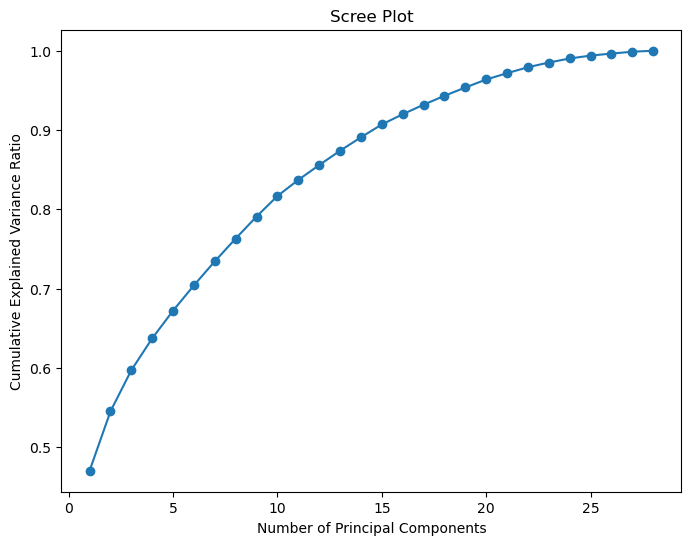

In [258]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 입력 변수 선택
X = df.drop(['Time', 'Amount', 'Class'], axis=1)

# PCA 객체 생성
pca = PCA()

# PCA 적용 및 설명된 분산 비율 계산
pca.fit(X)
exp_var_ratios = pca.explained_variance_ratio_

# 설명된 분산 비율 누적합 계산
cum_exp_var_ratios = exp_var_ratios.cumsum()

# 설명된 분산 비율 시각화
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(exp_var_ratios)+1), cum_exp_var_ratios, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

80% 수준의 설명력을 가지는 10개의 컴포넌트로 차원을 구성한다

In [259]:
from sklearn.ensemble import IsolationForest
# PCA 적용
pca = PCA(n_components=10)  # 10개의 주성분으로 축소
X_pca = pca.fit_transform(X)

# 이상치 탐지 모델링 (Isolation Forest)
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_pca)
outlier_scores = model.decision_function(X_pca)

# 이상치 판별 (임계값 조정)
thresholds = [-0.2, -0.1, 0.0, 0.1, 0.2]
for threshold in thresholds:
    outlier_indices = (outlier_scores < threshold).nonzero()[0]
    outliers = data.iloc[outlier_indices]
    print(f"Threshold: {threshold}, 이상치 개수: {len(outliers)}")

Threshold: -0.2, 이상치 개수: 51
Threshold: -0.1, 이상치 개수: 194
Threshold: 0.0, 이상치 개수: 590
Threshold: 0.1, 이상치 개수: 2731
Threshold: 0.2, 이상치 개수: 5900


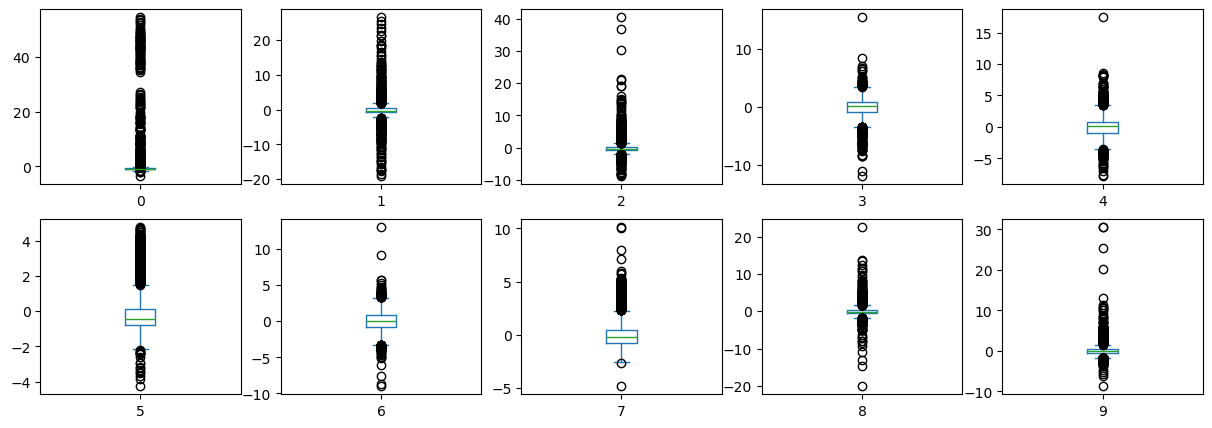

In [260]:
pd.DataFrame(X_pca).plot(kind = 'box', subplots = True, 
                         layout = (2,5), figsize = (15, 5));

In [261]:
from sklearn.manifold import TSNE
X = df.drop(['Time', 'Amount', 'Class'], axis=1)

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# 이상치 탐지 모델링 (Isolation Forest)
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_tsne)
outlier_scores = model.decision_function(X_tsne)

# 이상치 판별 (임계값 조정)
thresholds = [-0.2, -0.1, 0.0, 0.1, 0.2]
for threshold in thresholds:
    outlier_indices = (outlier_scores < threshold).nonzero()[0]
    outliers = data.iloc[outlier_indices]
    print(f"Threshold: {threshold}, 이상치 개수: {len(outliers)}")

Threshold: -0.2, 이상치 개수: 0
Threshold: -0.1, 이상치 개수: 0
Threshold: 0.0, 이상치 개수: 590
Threshold: 0.1, 이상치 개수: 4658
Threshold: 0.2, 이상치 개수: 5900


In [241]:
X_pca.shape

(5900, 10)

In [ ]:
# 시각화
# 이상치 판별
threshold = 0  # 임계값 조정
outlier_indices = (outlier_scores < threshold).nonzero()[0]
outliers = df.iloc[outlier_indices]
true = (df['Class']==1)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, label='Normal', alpha=0.3)
plt.scatter(X_pca[outlier_indices, 0], X_pca[outlier_indices, 1], s=5, marker='x', c='r', label='Outlier', alpha=0.6)
plt.scatter(X_pca[true, 0], X_pca[true, 1], s=5, marker='v', c='g', label='Label', alpha=0.3)

plt.title('Outlier Detection with PCA and Isolation Forest')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

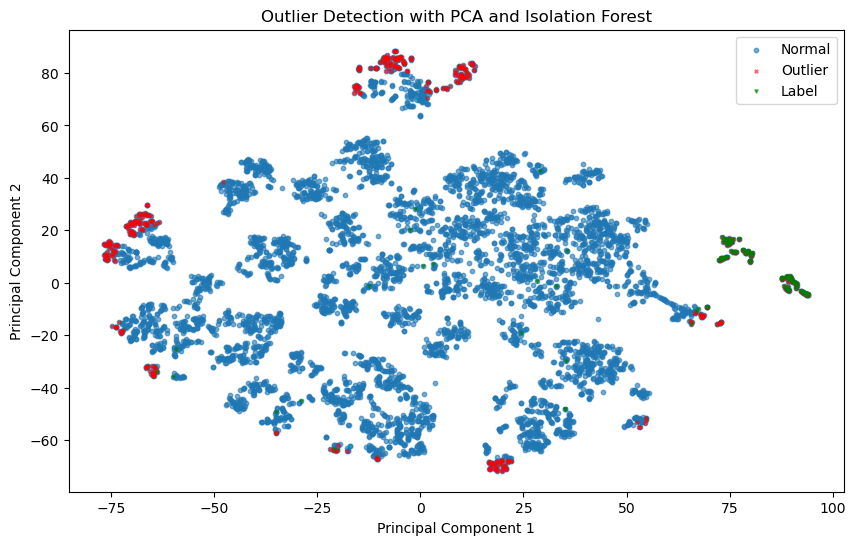

In [263]:
# 시각화
# 이상치 판별
threshold = 0  # 임계값 조정
outlier_indices = (outlier_scores < threshold).nonzero()[0]
outliers = df.iloc[outlier_indices]
true = (df['Class']==1)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, label='Normal', alpha=0.6)
plt.scatter(X_tsne[outlier_indices, 0], X_tsne[outlier_indices, 1], s=5, marker='x', c='r', label='Outlier', alpha=0.6)
plt.scatter(X_tsne[true, 0], X_tsne[true, 1], s=5, marker='v', c='g', label='Label', alpha=0.6)


plt.title('Outlier Detection with PCA and Isolation Forest')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

- TSNE가 더 잘 잡아내는 현상 확인하였음

### 1-3. 오버샘플링과 언더샘플링 장단점 비교하고 택1하여 해당 샘플링을 진행한 후, 해당 데이터로 이상치 탐지 모델링을 진행하시오.

In [160]:
df.Class.value_counts()

Class
0    5723
1     177
Name: count, dtype: int64

이상치 탐지 문제에서도 이상치와 정상 데이터의 비율이 불균형할 수 있으므로, 샘플링 기법을 적용할 수 있다

**오버샘플링 (Over-sampling)**
- 장점
  - 소수 클래스(이상치)의 데이터를 증가시켜 모델의 성능을 향상시킬 수 있음.
  - 기존 데이터를 모두 활용할 수 있음.
- 단점
  - 과적합(overfitting) 문제 발생가능
  - 데이터 복제로 인해 실제 데이터 분포와 다를 수 있음

**언더샘플링 (Under-sampling)**
- 장점
  - 과적합 문제를 줄일 수 있음
  - 계산 속도 향상
- 단점
  - 다수 클래스(정상 데이터)의 데이터를 제거하므로 정보 손실이 발생 가능
  - 극단적인 경우 데이터가 부족

이번 예시에서는 샘플 수가 작아서 오버샘플링을 적용 필요

```python

```

이 코드에서는 SMOTE(Synthetic Minority Over-sampling Technique) 알고리즘을 사용하여 오버샘플링을 수행

1. SMOTE는 소수 클래스(이상치)의 데이터를 합성하여 증가
2. 오버샘플링 후에는 TSNE를 사용하여 2차원으로 차원 축소를 수행. 
3. Isolation Forest 알고리즘을 사용하여 이상치 탐지 모델을 학습
4. 모델 학습 후에는 임계값을 설정하여 이상치를 판별하고, 해당 데이터를 출력

- 오버샘플링을 통해 이상치 데이터가 증가하면서 모델의 성능이 향상될 것으로 기대되나 과적합 문제가 발생할 수 있으므로, 모델 평가와 하이퍼파라미터 튜닝이 필요
- 또한, 언더샘플링을 적용해보고 성능을 비교해볼 수도 있습니다. 데이터의 특성과 목적에 따라 적절한 샘플링 기법을 선택하는 것이 중요

In [330]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

# 오버샘플링 (SMOTE)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42)
X_tsne_r = tsne.fit_transform(X_resampled)

# 이상치 탐지 모델링 (Isolation Forest)
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_tsne_r)
outlier_scores_r = model.decision_function(X_tsne_r)


threshold = 0  # 임계값 조정
# outlier_indices = (outlier_scores < threshold).nonzero()[0]
# outliers = df.iloc[outlier_indices]
# # true = (df['Class']==1)

# # 유효한 인덱스만 선택
valid_indices = outlier_indices[outlier_indices < len(X_resampled)]
outliers_r = X_resampled.iloc[valid_indices]

print("이상치 개수:", len(outliers))
outliers.head()

이상치 개수: 590


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,pred
9,52.0,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,1.46,0,1
29,259.0,-1.569485,-1.932133,1.249203,-4.434211,1.244282,0.402688,-0.649554,0.534756,0.886183,...,0.397405,0.199030,-1.386013,-0.141955,-0.984011,0.274079,-0.019784,55.45,0,1
44,335.0,1.295946,1.011835,-3.191860,0.471478,3.350241,2.432783,0.189553,0.621734,-0.556702,...,-0.825372,-0.245258,0.674749,1.010841,-0.279061,0.040542,0.090574,4.80,0,1
53,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,1
65,513.0,0.166862,1.667709,-2.095559,1.835206,0.876545,-1.481721,-0.323575,-2.866382,-0.573338,...,0.207549,0.550348,-0.006635,-0.554034,-0.421468,0.007827,-0.039904,1.00,0,1


### 1-4. 1-2에서 만든 모델과 1-3에서 만든 모델을 비교하고, 최종 선택 하시오.

- 1-2번 모델의 예측

In [331]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

pca = PCA(n_components=10)  # 10개의 주성분으로 축소
X_pca = pca.fit_transform(X)


# 이상치 탐지 모델링 (Isolation Forest)
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_pca)
outlier_scores = model.decision_function(X_pca)

thresholds =  -0.2

outlier_indices = (outlier_scores < threshold).nonzero()[0]
outliers = df.iloc[outlier_indices]
df['pred'] = 0
df.loc[outlier_indices,'pred']=1


preds = df['pred'].values
y_true = df['Class'].values
print(classification_report(y_true,preds))
print(confusion_matrix(y_true,preds))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      5723
           1       0.25      0.85      0.39       177

    accuracy                           0.92      5900
   macro avg       0.62      0.89      0.67      5900
weighted avg       0.97      0.92      0.94      5900

[[5283  440]
 [  27  150]]


1종오류가 다소 발생하였으나, 전반적으로 잘 예측한 것을 확인하였음

- 1-3번 모델의 예측

In [336]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(['Time', 'Amount', 'Class'], axis=1)

pca = PCA(n_components=10)  # 10개의 주성분으로 축소
X_pca = pca.fit_transform(X_resampled)

# 이상치 탐지 모델링 (Isolation Forest)
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_pca)
outlier_scores = model.decision_function(X_pca)

# 이상치 판별 (임계값 조정)
thresholds = 0.1

outlier_indices = (outlier_scores < thresholds).nonzero()[0]
outliers = X_resampled.iloc[outlier_indices]

preds = pd.Series(np.zeros(len(y_resampled)))
preds[outlier_indices]=1     

y_true = y_resampled

print(classification_report(y_true,preds))
print(confusion_matrix(y_true,preds))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      5723
           1       0.74      0.76      0.75      5723

    accuracy                           0.75     11446
   macro avg       0.75      0.75      0.75     11446
weighted avg       0.75      0.75      0.75     11446

[[4204 1519]
 [1355 4368]]


오히려 예측점수가 떨어진 것을 확인, 1-2 즉 오버샘플링을 진행하기 전에 더 잘 예측함을 알수 있다 

# 과제 2. 구매데이터 군집분석 문제  
[데이터 설명]
> - nvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.
> - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
> - Description: Product (item) name. Nominal.
> - Quantity: The quantities of each product (item) per transaction. Numeric.
> - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
> - UnitPrice: Unit price. Numeric, Product price per unit in sterling.
> - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
> - Country: Country name. Nominal, the name of the country where each customer resides.
- ADP 실기 26회 기출문제: https://www.datamanim.com/dataset/ADPpb/00/26.html

### 2-1. 결측치를 확인하고, 결측치 제거할 것

In [364]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem1.csv')
resume(df)

(35801, 8)


,dtype,isna,nunique,1st,2nd
InvoiceNo,object,0,1846,563808,561645
StockCode,object,0,2668,22432,23166
Description,object,0,2763,WATERING CAN PINK BUNNY,MEDIUM CERAMIC TOP STORAGE JAR
Quantity,float64,25,124,6.0,12.0
InvoiceDate,object,0,1827,8/19/2011 11:46,7/28/2011 15:16
UnitPrice,float64,97,162,1.95,1.25
CustomerID,float64,0,289,12626.0,14911.0
Country,object,0,8,Germany,EIRE


In [365]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,12626.0,Germany
1,561645,23166,MEDIUM CERAMIC TOP STORAGE JAR,12.0,7/28/2011 15:16,1.25,14911.0,EIRE
2,568651,20985,HEART CALCULATOR,12.0,9/28/2011 12:04,1.25,12362.0,Belgium
3,541711,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,24.0,1/21/2011 11:18,1.25,14646.0,Netherlands
4,554134,21154,RED RETROSPOT OVEN GLOVE,10.0,5/23/2011 9:48,1.25,12583.0,France
...,...,...,...,...,...,...,...,...
35796,554137,21668,RED STRIPE CERAMIC DRAWER KNOB,12.0,5/23/2011 10:13,1.25,12708.0,Germany
35797,572986,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,6.0,10/27/2011 10:51,3.25,12681.0,France
35798,579927,22734,SET OF 6 RIBBONS VINTAGE CHRISTMAS,6.0,12/1/2011 9:20,2.89,12572.0,Germany
35799,551163,22431,WATERING CAN BLUE ELEPHANT,1.0,4/26/2011 15:52,1.95,12573.0,France


Quantity,UnitPrice에 이상치 확인, 수가 적으므로 DROP

In [356]:
df.dropna(inplace=True,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35679 entries, 0 to 35800
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    35679 non-null  object 
 1   StockCode    35679 non-null  object 
 2   Description  35679 non-null  object 
 3   Quantity     35679 non-null  float64
 4   InvoiceDate  35679 non-null  object 
 5   UnitPrice    35679 non-null  float64
 6   CustomerID   35679 non-null  float64
 7   Country      35679 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.4+ MB


### 2-2. 이상치 제거하는 방법을 설명하고, 이상치 제거하고 난 결과를 통계적으로 나타낼 것

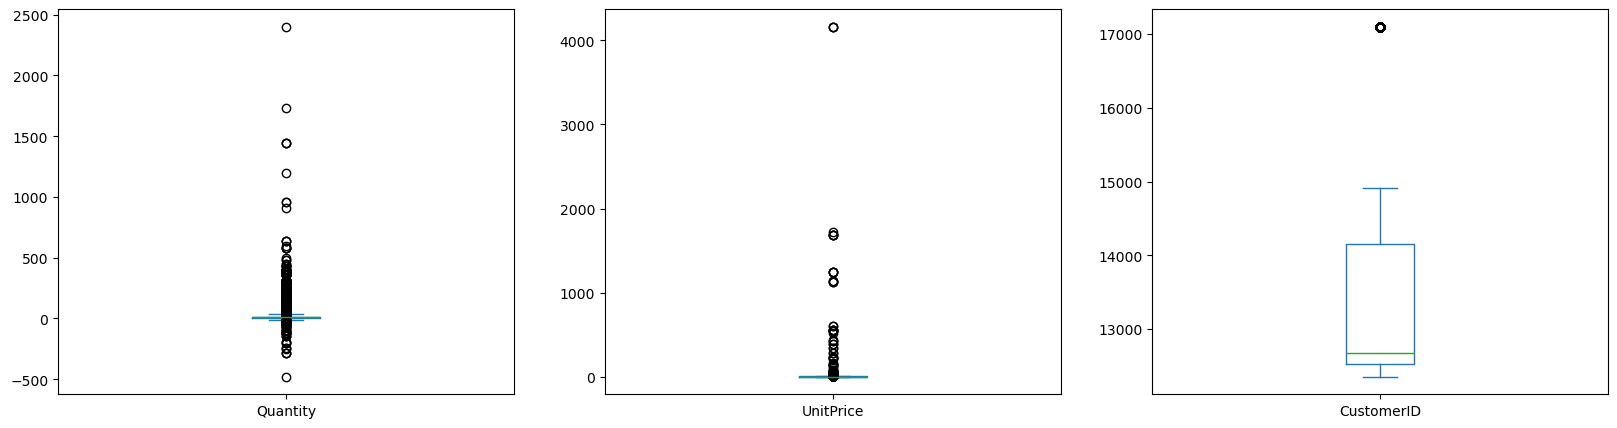

In [357]:
df.select_dtypes('number').plot(kind='box', subplots= True, figsize=(20,5));

- 이상치를 제거하려면 log화를 진행하거나, 역수치환의 방식 또는
- IQR로 분위수 기준으로 이상치를 제거, 표준편차 기준으로 신뢰도에 따라 제거하는 방법이 있다.

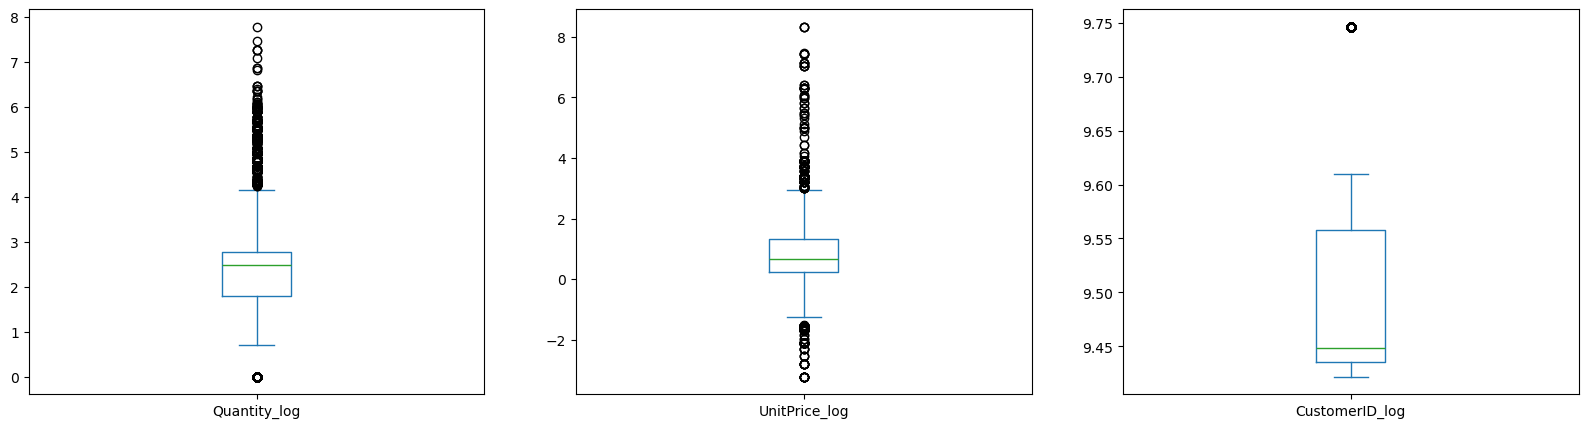

In [358]:
num = df.select_dtypes('number').columns
for n in num:
    df[n+'_log']=df[n].apply(lambda x: np.log(x))
num_log = df.iloc[:,-3:].columns
df[num_log].plot(kind='box', subplots= True, figsize=(20,5));

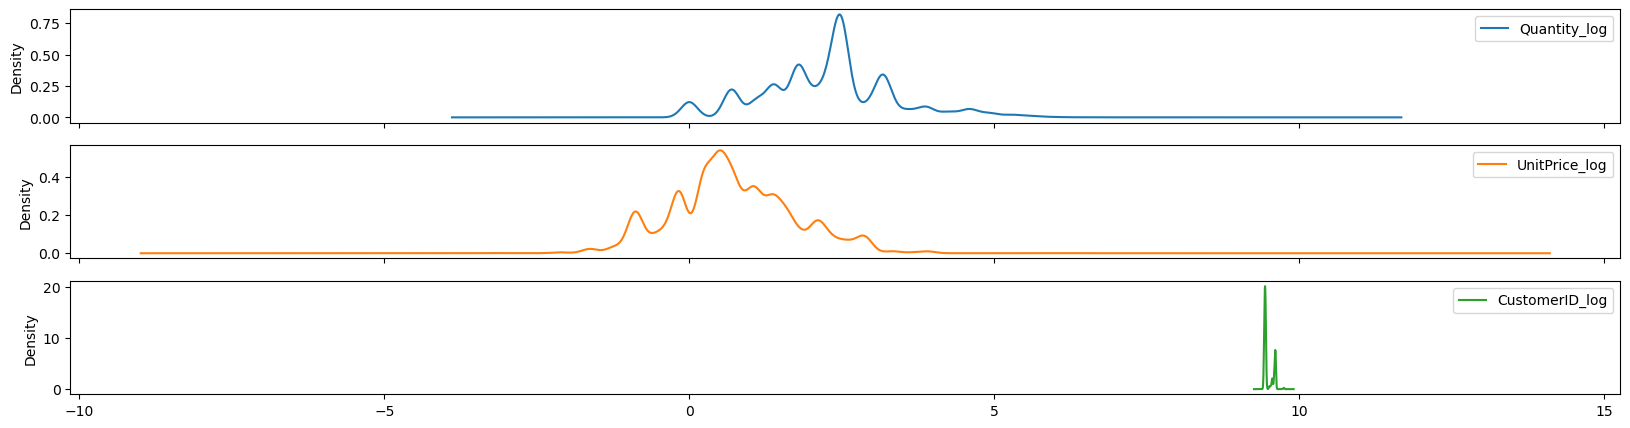

In [362]:
df[num_log] = df[num_log].replace([np.inf, -np.inf], np.nan) # 마이너스 무한대를 삭제
df[num_log].plot(kind='kde', subplots= True, figsize=(20,5)); # 정규분포와 비슷한 종모양

### 2-3. F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 군집분석 방법들 중 택2 하여 군집을 생성할 것, 군집을 생성한 과정을 각각 설명할 것

1. k-means

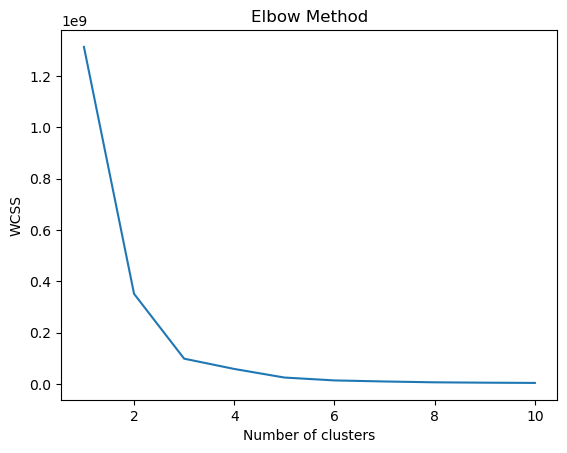

In [368]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(customer_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [369]:
from sklearn.cluster import KMeans

# F와 M 특성 생성
customer_data = df.groupby('CustomerID').agg({'InvoiceNo': 'count', 'UnitPrice': 'sum'})
customer_data.columns = ['F', 'M']

# K-means 군집화 수행
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(customer_data)
customer_data['cluster'] = kmeans.labels_
customer_data

,F,M,cluster
CustomerID,,,
12354.0,58,257.07,0
12356.0,59,188.87,0
12357.0,131,438.67,0
12361.0,10,33.35,0
12362.0,274,1080.74,0
...,...,...,...
14277.0,228,872.14,0
14335.0,63,144.24,0
14646.0,2085,5396.77,2


2. 계층적 군집화
- 계층적 군집화는 데이터 포인트 간의 유사성을 기반으로 군집을 형성하는 방법

dendrogram 함수를 사용하여 덴드로그램을 시각화합니다. truncate_mode='level'과 p=5는 5개의 군집으로 잘라내어 표시합니다.

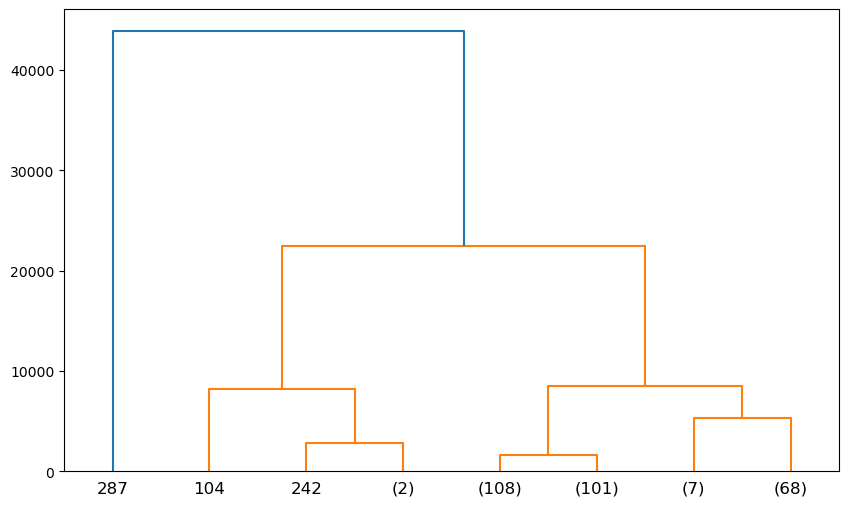

In [372]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 계층적 군집화 수행
Z = linkage(customer_data, method='ward') # linkage 함수를 사용하여 F와 M 특성으로 계층적 군집화.  Ward 연결 사용

# 덴드로그램 시각화
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=3)
cluster_labels = fcluster(Z, t=3, criterion='maxclust')
customer_data['hier_cluster'] = cluster_labels
plt.show()

In [373]:
customer_data

,F,M,cluster,hier_cluster
CustomerID,,,,
12354.0,58,257.07,0,2
12356.0,59,188.87,0,2
12357.0,131,438.67,0,2
12361.0,10,33.35,0,2
12362.0,274,1080.74,0,2
...,...,...,...,...
14277.0,228,872.14,0,2
14335.0,63,144.24,0,2
14646.0,2085,5396.77,2,1


### 2-4. 둘 중에 한 모델을 선택하고, 그 이유를 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

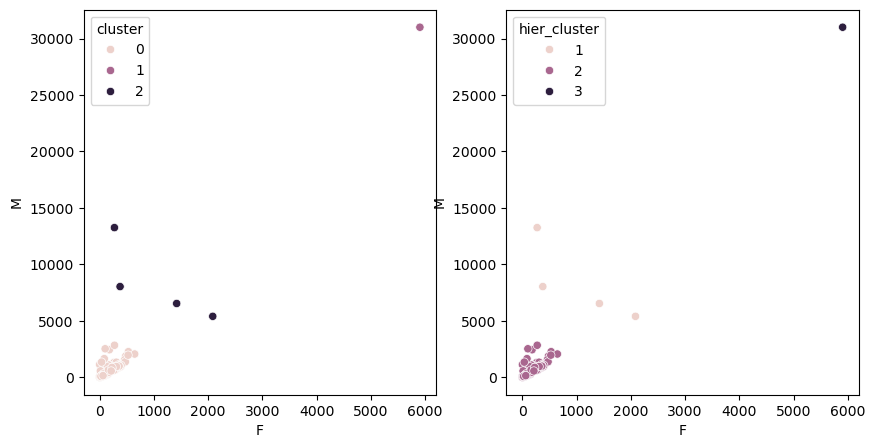

In [384]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = ['cluster','hier_cluster']
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes = np.ravel(axes)
for ax, label in zip(axes, labels):
    sns.scatterplot(data = customer_data,x='F',y='M', hue=label, ax=ax)

### 2-5. 선택한 모델을 기반으로 생성한 군집들의 특성을 분석할 것

K-means 군집화

- K-means 군집화를 통해 생성된 군집들의 특성을 분석하기 위해서는 각 군집의 중심점(centroid)을 살펴보는 것이 좋습니다. 중심점은 각 군집의 대표값을 나타내므로, 이를 통해 군집의 특성을 파악

출력 결과를 보면 각 군집의 F(소비자별 구매빈도)와 M(소비자별 총 구매액)의 중심값을 확인

In [387]:
# 군집 중심점 출력
print(kmeans.cluster_centers_)

[[   90.6443662    353.68489437]
 [ 5903.         31001.55      ]
 [ 1038.75        8304.7075    ]]


- 첫번째 군집의 중심점이 (90.6, 353.7)로 구매빈도가 90.6회, 총 구매액이 353.7인 고객들로 구성
- 두번째 군집은 구매빈도 5903회, 총구매액 31001
- 세번째 군집은 구매빈도 1038회, 총구매액 8304


In [386]:
# 각 군집의 크기 출력
print(customer_data['cluster'].value_counts())

cluster
0    284
2      4
1      1
Name: count, dtype: int64


- 각 군집의 크기(고객 수)를 확인하면 군집 간 차이를 파악

### 2-6. 각 군집 별 대표 추천 상품을 도출할 것

In [403]:
df_= df.set_index('CustomerID')
df_

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
CustomerID,,,,,,,
12626.0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,Germany
14911.0,561645,23166,MEDIUM CERAMIC TOP STORAGE JAR,12.0,7/28/2011 15:16,1.25,EIRE
12362.0,568651,20985,HEART CALCULATOR,12.0,9/28/2011 12:04,1.25,Belgium
14646.0,541711,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,24.0,1/21/2011 11:18,1.25,Netherlands
12583.0,554134,21154,RED RETROSPOT OVEN GLOVE,10.0,5/23/2011 9:48,1.25,France
...,...,...,...,...,...,...,...
12708.0,554137,21668,RED STRIPE CERAMIC DRAWER KNOB,12.0,5/23/2011 10:13,1.25,Germany
12681.0,572986,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,6.0,10/27/2011 10:51,3.25,France
12572.0,579927,22734,SET OF 6 RIBBONS VINTAGE CHRISTMAS,6.0,12/1/2011 9:20,2.89,Germany


In [410]:
cluster_1_customers = df[df['CustomerID'].isin(customer_data[customer_data['cluster'] == 1].index)]
cluster_2_customers= df[df['CustomerID'].isin(customer_data[customer_data['cluster'] == 2].index)]
cluster_0_customers= df[df['CustomerID'].isin(customer_data[customer_data['cluster'] == 0].index)]
cluster_1_customers['Description'].value_counts()[:5]

Description
CARRIAGE                              85
REGENCY CAKESTAND 3 TIER              56
ROSES REGENCY TEACUP AND SAUCER       36
WHITE HANGING HEART T-LIGHT HOLDER    34
GREEN REGENCY TEACUP AND SAUCER       30
Name: count, dtype: int64

In [427]:
cluster_2_customers['Description'].value_counts()[:15]

Description
SPACEBOY LUNCH BOX                     29
ROUND SNACK BOXES SET OF4 WOODLAND     26
DOLLY GIRL LUNCH BOX                   25
LUNCH BAG RED RETROSPOT                24
JUMBO BAG RED RETROSPOT                22
SET OF 3 REGENCY CAKE TINS             21
REGENCY CAKESTAND 3 TIER               21
RED RETROSPOT CHARLOTTE BAG            19
WOODLAND CHARLOTTE BAG                 19
ROUND SNACK BOXES SET OF 4 FRUITS      18
LUNCH BAG WOODLAND                     18
PACK OF 72 RETROSPOT CAKE CASES        18
PLASTERS IN TIN SPACEBOY               18
POSTAGE                                18
JAM MAKING SET WITH JARS               17
Name: count, dtype: int64

In [412]:
cluster_0_customers['Description'].value_counts()[:5]

Description
POSTAGE                                938
ROUND SNACK BOXES SET OF4 WOODLAND     253
REGENCY CAKESTAND 3 TIER               195
PLASTERS IN TIN WOODLAND ANIMALS       173
ROUND SNACK BOXES SET OF 4 FRUITS      157
Name: count, dtype: int64

### 2-7. CustomerID가 12413인 고객을 대상으로 상품을 추천할 것

In [433]:
df_.loc[12413.0,:].groupby('Description').agg({'Quantity':'sum'}).sort_values(by='Quantity',ascending=False).index

Index(['JUMBO BAG RED RETROSPOT', '10 COLOUR SPACEBOY PEN',
       'RED RETROSPOT CHARLOTTE BAG', 'CHARLOTTE BAG PINK POLKADOT',
       'ROUND SNACK BOXES SET OF4 WOODLAND ', 'RED RETROSPOT PICNIC BAG',
       'STARS GIFT TAPE ', 'BALLOONS  WRITING SET ',
       'SET/6 RED SPOTTY PAPER PLATES', 'SET/6 RED SPOTTY PAPER CUPS',
       'SET/20 RED RETROSPOT PAPER NAPKINS ', 'BAKING SET 9 PIECE RETROSPOT ',
       'PLASTERS IN TIN STRONGMAN', 'JUMBO BAG ALPHABET',
       'RED RETROSPOT SHOPPING BAG', 'RED RETROSPOT MINI CASES',
       'NATURAL SLATE HEART CHALKBOARD ', 'POPPY'S PLAYHOUSE KITCHEN',
       'FELTCRAFT DOLL MOLLY', 'BLACK/BLUE POLKADOT UMBRELLA',
       'BAKING SET SPACEBOY DESIGN', 'HOME SWEET HOME CUSHION COVER ',
       'FELTCRAFT PRINCESS LOLA DOLL', 'EDWARDIAN PARASOL RED',
       'TOOL BOX SOFT TOY ', 'RECYCLED ACAPULCO MAT BLUE', 'POSTAGE',
       'CHILDS BREAKFAST SET SPACEBOY ', 'CABIN BAG VINTAGE RETROSPOT'],
      dtype='object', name='Description')

In [424]:
customer_data.loc[12413.0,:]

F                40.00
M               210.29
cluster           0.00
hier_cluster      2.00
Name: 12413.0, dtype: float64

2번클러스터에 있음

In [440]:
cluster_2_customers['Description'].value_counts()[:10].keys()

Index(['SPACEBOY LUNCH BOX ', 'ROUND SNACK BOXES SET OF4 WOODLAND ',
       'DOLLY GIRL LUNCH BOX', 'LUNCH BAG RED RETROSPOT',
       'JUMBO BAG RED RETROSPOT', 'SET OF 3 REGENCY CAKE TINS',
       'REGENCY CAKESTAND 3 TIER', 'RED RETROSPOT CHARLOTTE BAG',
       'WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF 4 FRUITS '],
      dtype='object', name='Description')

같은 클러스터의 고객이 구매한 아이템 Top10 중 아직 구매경험이 없는 것을 추천한다

In [441]:
As=df_.loc[12413.0,:].groupby('Description').agg({'Quantity':'sum'}).sort_values(by='Quantity',ascending=False).index
Bs=cluster_2_customers['Description'].value_counts()[:10].keys()
reco = []
for b in Bs:
    if b not in(As):reco.append(b)

In [442]:
reco

['SPACEBOY LUNCH BOX ',
 'DOLLY GIRL LUNCH BOX',
 'LUNCH BAG RED RETROSPOT',
 'SET OF 3 REGENCY CAKE TINS',
 'REGENCY CAKESTAND 3 TIER',
 'WOODLAND CHARLOTTE BAG',
 'ROUND SNACK BOXES SET OF 4 FRUITS ']

## 과제 3. 연관규칙학습 문제
- 출처: https://zephyrus1111.tistory.com/119

### 3-1. 어느 대형 마트의 거래 내역이 다음과 같이 주어졌을때 각 거래품목에 대한 거래 여부를 표시하는 데이터로 전처리 하시오

In [453]:
import pandas as pd

buy = [['삼겹살', '상추'],
        ['삼겹살', '상추', '사이다'], 
        ['삼겹살', '깻잎'],
        ['닭고기', '샤워 타올'], 
        ['닭고기', '콜라', '사이다']]

# 모든 고유 품목 추출
unique_descriptions = set(item for sublist in buy for item in sublist)
unique_descriptions = list(unique_descriptions)

# 새로운 데이터프레임 생성
new_df = pd.DataFrame(columns=unique_descriptions)

# 각 거래에 대한 행 추가
for i, transaction in enumerate(buy):
    new_df.loc[i] = pd.Series({item: 1 for item in transaction}, index=unique_descriptions).fillna(0)

new_df


,상추,샤워 타올,닭고기,깻잎,사이다,콜라,삼겹살
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### 3-2. 최소 지지도가 0.3인 빈발항목 집합을 생성하시오.

In [457]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# 데이터 준비
transactions = [
    ['삼겹살', '상추'],
    ['삼겹살', '상추', '사이다'],
    ['삼겹살', '깻잎'],
    ['닭고기', '샤워 타올'],
    ['닭고기', '콜라', '사이다']
]

# 데이터 인코딩
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 빈발항목 집합 생성
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

# 결과 출력
print(frequent_itemsets)

   support   itemsets
0      0.4      (닭고기)
1      0.4      (사이다)
2      0.6      (삼겹살)
3      0.4       (상추)
4      0.4  (삼겹살, 상추)


### 3-3. 최소 신뢰도 0.5 기준으로 연관규칙을 만들고, 그 중 향상도 1 이상인 것들을 나타내시오.

In [459]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# 데이터 준비
transactions = [
    ['삼겹살', '상추'],
    ['삼겹살', '상추', '사이다'],
    ['삼겹살', '깻잎'],
    ['닭고기', '샤워 타올'],
    ['닭고기', '콜라', '사이다']
]

# 데이터 인코딩
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 빈발항목 집합 생성
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

# 연관규칙 생성
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)

# 향상도 1 이상인 규칙 필터링
rules_lift_1 = rules[rules['lift'] >= 1]

# 결과 출력
rules_lift_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(삼겹살),(상추),0.6,0.4,0.4,0.666667,1.666667,0.16,1.8,1.000000
1,(상추),(삼겹살),0.4,0.6,0.4,1.000000,1.666667,0.16,inf,0.666667


### 3-4. 결과를 해석하시오.


이 결과는 최소 신뢰도 0.5 기준으로 생성된 연관규칙을 보여줌:



- antecedents: 규칙의 전제부(If 부분)
- consequents: 규칙의 결론부(Then 부분)
- antecedent support: 전제부 항목 집합의 지지도
- consequent support: 결론부 항목 집합의 지지도
- support: 규칙 전체의 지지도
- confidence: 규칙의 신뢰도
- lift: 규칙의 향상도
- leverage: 규칙의 레버리지
- conviction: 규칙의 컨빅션 값
- zhangs_metric: 규칙의 장스 메트릭 값


> 이 결과를 해석하면



- (삼겹살) -> (상추) 규칙:


- 전제부 (삼겹살)의 지지도는 0.6, 결론부 (상추)의 지지도는 0.4
- 이 규칙의 지지도는 0.4, 신뢰도는 0.667(약 67%)
- 향상도는 1.667로, 삼겹살을 구매한 고객이 상추를 구매할 확률이 전체 고객이 상추를 구매할 확률보다 1.667배 높음

- (상추) -> (삼겹살) 규칙:


- 전제부 (상추)의 지지도는 0.4, 결론부 (삼겹살)의 지지도는 0.6입니다.
- 이 규칙의 지지도는 0.4, 신뢰도는 1.0(100%)
- 향상도는 1.667로, 상추를 구매한 고객이 삼겹살을 구매할 확률이 전체 고객이 삼겹살을 구매할 확률보다 1.667배 높음


> 삼겹살과 상추는 서로 연관성이 높은 품목임. 특히 상추를 구매한 고객은 삼겹살을 구매할 확률이 매우 높음(신뢰도 100%). 따라서 이 두 품목을 함께 판매하거나 프로모션을 진행하면 효과적일 것으로 예상